In [1]:
from lerobot.common.datasets.lerobot_dataset import LeRobotDataset
from PIL import Image
import numpy as np
from airo_robots.grippers.hardware.robotiq_2f85_urcap import Robotiq2F85
from airo_robots.manipulators.hardware.ur_rtde import URrtde
from airo_spatial_algebra.se3 import SE3Container, normalize_so3_matrix
import time

/fast_storage/qnoens/conda/robilglue/lib/python3.10/site-packages/datasets/__init__.py


### Load the dataset we want to replay to check if it was properly recorded.

In [2]:
root_dataset_dir = '/fast_storage/qnoens/OpenVLA/data/full_lerobot_task1_zero_action'
dataset_name = 'test_dataset'

lerobot_dataset = LeRobotDataset(repo_id=dataset_name, root=root_dataset_dir)
meta = lerobot_dataset.meta
print(meta)

Resolving data files:   0%|          | 0/101 [00:00<?, ?it/s]

LeRobotDatasetMetadata({
    Repository ID: 'test_dataset',
    Total episodes: '101',
    Total frames: '13303',
    Features: '['next.reward', 'next.success', 'seed', 'timestamp', 'wrist_image_original', 'scene_image_original', 'wrist_image', 'scene_image', 'state', 'robot_pose', 'gripper_state', 'joints', 'action', 'frame_index', 'episode_index', 'index', 'task_index']',
})',



### Connect to the gripper and robot

In [3]:
ip = "10.42.0.162"

gripper = Robotiq2F85(ip)
robot = URrtde(ip, URrtde.UR3E_CONFIG, gripper=gripper)

### Choose an episode index you want to verify

In [4]:
ep_idx = 1

### Loading episode

The language instruction of this episode: move the block to the blue target
The inital state of the robot, try to replicate the positions of all the objects in the scene:


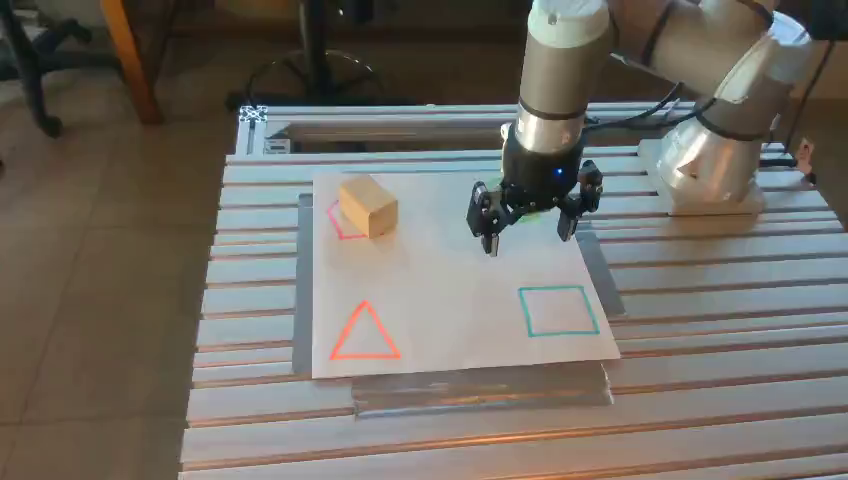

In [5]:
episode_meta = meta.episodes[ep_idx]
instruction = episode_meta['tasks'][0]
episode_length = episode_meta['length']

lengths = [meta.episodes[i]['length'] for i in range(ep_idx)]
start_idx = sum(lengths)

frame = lerobot_dataset[start_idx]['scene_image_original']
frame = frame.permute(1, 2, 0).numpy()
frame = (frame * 255).astype(np.uint8)
image = Image.fromarray(frame)

print("The language instruction of this episode:", instruction)
print("The inital state of the robot, try to replicate the positions of all the objects in the scene:")
display(image)

In [6]:
all_actions = []
for frame_idx in range(start_idx, start_idx + episode_length):
    action = lerobot_dataset[frame_idx]['action'].numpy()
    all_actions.append(action)

### Helper functions that will help us execute all the actions in the episode

In [7]:

def convert_relative_to_absolute_action(current_robot_pose, current_gripper_width, action: np.ndarray):
    """
    Convert a relative action to an absolute action
    Args:
        action: [x,y,z, rx,ry,rz,gripper]. relative target pose in robot base frame (euler angles) and absolute gripper width
        current_robot_pose: [x,y,z, rx,ry,rz]. current robot pose in robot base frame using Euler angles
        current_gripper_width: current gripper width

    Returns:
        target_pose_se3: target pose in matrix form in robot base frame
        target_gripper_width: target gripper width
    """
    current_robot_pose_se3 = SE3Container.from_euler_angles_and_translation(
        current_robot_pose[3:6], current_robot_pose[0:3]
    ).homogeneous_matrix

    relative_robot_pose = SE3Container.from_euler_angles_and_translation(
        action[3:6], action[0:3]
    ).homogeneous_matrix
    target_pose_se3 = current_robot_pose_se3 @ relative_robot_pose

    target_gripper_width = action[6] + current_gripper_width

    return target_pose_se3, target_gripper_width

def act(robot_pose_se3, gripper_pose, timestamp):
    """
    Move the robot to the target pose and gripper width
    Args:
        robot_pose_se3: target pose in matrix form in robot base frame
        gripper_pose: target gripper width
        timestamp: target timestamp
    """

    if isinstance(gripper_pose, np.ndarray):
        gripper_pose = gripper_pose[0].item()

    # move robot to target pose
    current_time = time.time()
    duration = timestamp - current_time
    if duration < 0:
        duration = 0

    robot_pose_se3[:3, :3] = normalize_so3_matrix(robot_pose_se3[:3, :3])
    robot.servo_to_tcp_pose(robot_pose_se3, duration)
    #robot.move_to_tcp_pose(robot_pose_se3).wait() # this was robot.move_to_tcp_pose, with second arg = duration

    # move gripper to target width
    gripper_width = np.clip(
        gripper_pose, gripper.gripper_specs.min_width, 0.085
    )
    gripper._set_target_width(gripper_width)

    # do not wait, handling timings is the responsibility of the caller
    return

def convert_tcp_pose_to_joints(tcp_pose_se3):
    """
    Convert a TCP pose to joint configuration
    Args:
        tcp_pose_se3: tcp pose in matrix form in robot base frame

    Returns:
        [q1,q2,q3,q4,q5,q6]. joint configuration
    """
    tcp_pose_se3[:3, :3] = normalize_so3_matrix(tcp_pose_se3[:3, :3])
    joints = robot.inverse_kinematics(tcp_pose_se3)
    return joints

def tcp_matrix_to_euler_and_translation(tcp_matrix):
    """
    Convert a TCP matrix to euler angles and translation
    Args:
        tcp_matrix: [x,y,z, rx,ry,rz]. target pose in robot base frame (rotation vector)

    Returns:
        [x,y,z, rx,ry,rz]. target pose in robot base frame (euler angles)
    """
    euler_angles = SE3Container.from_homogeneous_matrix(tcp_matrix).orientation_as_euler_angles
    translation = SE3Container.from_homogeneous_matrix(tcp_matrix).translation
    return translation, euler_angles


### Bring the robot to its initial pose
*Note:* Both `state` and `robot_pose` might not correspond with the actual initial state you see on the image above. This is most likely due to the TCP position being set differently now in comparison to what is was set during the demonstration itself. To avoid problems with this, we will use the joint angles instead.

In [8]:
# Load the initial state of the robot in different forms
initial_state = lerobot_dataset[start_idx]['state'].numpy()
current_gripper_width = initial_state[-1]
robot_pose = lerobot_dataset[start_idx]['robot_pose'].numpy()
joints = lerobot_dataset[start_idx]['joints'].numpy()

# Note that both robot_pose and state are the same but WRONG
print("Pose:", robot_pose)
print("State:", initial_state)

# If we move the robot to this joints position, the intial state is correct
print("Joints:", joints)

# Bring the robot to this correct intial state
robot.move_to_joint_configuration(joints).wait()
gripper._set_target_width(current_gripper_width)

# Now, get the actual initial robot pose
robot_pose = robot.get_tcp_pose()
joints = convert_tcp_pose_to_joints(robot_pose)
print("Joints now that robot is initial state:", joints)

# Convert the robot pose to euler angles and translation
translation, euler = tcp_matrix_to_euler_and_translation(robot_pose)
state = np.concatenate((translation, euler))
print()
print("Here you can whether the initial state corresponds to the current robot pose")
print("Current Pose:", state)
print("Initial State:", initial_state)
print(np.isclose(initial_state[:-1], state, rtol=1e-03, atol=1e-03))


Pose: [ 0.11399951 -0.279432    0.15570731 -3.0783412  -0.03240277  0.16280837]
State: [ 0.11399951 -0.279432    0.15570731 -3.0783412  -0.03240277  0.16280837
  0.0838913 ]
Joints: [-0.7566994 -1.7115527 -2.1684253 -0.8621951  1.639528   3.793747 ]
Joints now that robot is initial state: [-0.7566307226764373, -1.7115284405150923, -2.1683797836303, -0.8622551721385658, 1.639514207839965, 3.793883562087988]

Here you can whether the initial state corresponds to the current robot pose
Current Pose: [ 0.11783223 -0.26753122 -0.01983614 -3.07835318 -0.03238897  0.16274125]
Initial State: [ 0.11399951 -0.279432    0.15570731 -3.0783412  -0.03240277  0.16280837
  0.0838913 ]
[False False False  True  True  True]


### Execute all the actions in the episode

In [9]:
for i in range(episode_length):
    # Get the next action to execute and the current robot pose and gripper width
    action = all_actions[i]
    current_tcp_pose = robot.get_tcp_pose()
    current_gripper_width = gripper.get_current_width()

    # Convert the current tcp pose to euler angles and translation
    translation, euler = tcp_matrix_to_euler_and_translation(current_tcp_pose)
    current_tcp_pose = np.concatenate((translation, euler))
    
    # Convert the action to a target pose and gripper width
    target_pose_se3, target_gripper_width = convert_relative_to_absolute_action(
        current_tcp_pose, current_gripper_width, action
    )

    # This one way to do it with joints
    target_joints = convert_tcp_pose_to_joints(target_pose_se3)
    gripper._set_target_width(target_gripper_width)
    robot.move_to_joint_configuration(target_joints).wait()

    # Alternative way would be without joints
    #act(target_pose_se3, target_gripper_width, time.time() + 0.1)